In [18]:
import os
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import folium

## Load geodataframe

In [5]:
geodf = gpd.read_file('./sandbox/mikes/MAR/output/output_mar.shp')
geodf.sample(n=3)

,window,left_x,right_x,top_y,bottom_y,left_lon,top_lat,right_lon,bottom_lat,center_lon,center_lat,count,nancount,tot_pop,split,t_hospital,so_hospita,geometry
899,250,12250,12500,3250,3500,-2.959167,33.214167,-2.750833,33.005833,-2.855000,33.110000,62500,62500,856.073120,1,3.672444,14520.735582,POINT (-2.85500 33.11000)
905,250,12000,12250,4250,4500,-3.167500,32.380833,-2.959167,32.172500,-3.063333,32.276667,62500,62500,821.020508,1,3.524306,9412.353104,POINT (-3.06333 32.27667)
541,250,8500,8750,3250,3500,-6.084167,33.214167,-5.875833,33.005833,-5.980000,33.110000,62500,62500,12545.833008,1,1.626167,3.532504,POINT (-5.98000 33.11000)


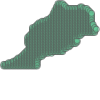

In [6]:
geodf.unary_union

## Qty of interest distribution

Plotting any quantity of interest distribution to get a grasp of what to expect from the mapping and how to tweak it to make it more expressive

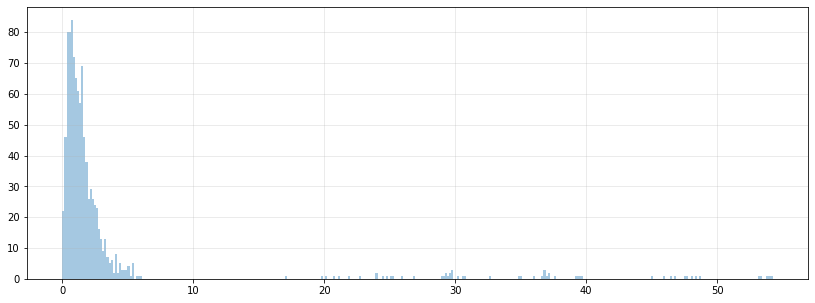

In [12]:
qty_interest = 't_hospital'

plt.figure(figsize=(14, 5))
sns.distplot(geodf[qty_interest].values, bins=len(geodf) // 3, kde=False)
plt.grid(alpha=0.3)
plt.show()

## Option 1 : Visualizing as Folium Choropleth

In [13]:
from shapely.geometry import point, polygon

__Transform parsing windows as polygons__

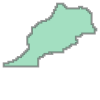

In [14]:
def make_polygon(row):
    p = polygon.Polygon(shell=[(row['left_lon'], row['top_lat']),
                               (row['left_lon'], row['bottom_lat']),
                               (row['right_lon'], row['bottom_lat']),
                               (row['right_lon'], row['top_lat'])])
    row['geometry'] = p
    return row


p_geodf = geodf.apply(make_polygon, axis=1)
p_geodf.unary_union

__Add index as columns for jointure of Polygon X Qty of interest under Choropeth layer__

In [15]:
p_geodf.reset_index(level=0, inplace=True)
p_geodf.sample(n=1)

,index,window,left_x,right_x,top_y,bottom_y,left_lon,top_lat,right_lon,bottom_lat,center_lon,center_lat,count,nancount,tot_pop,split,t_hospital,so_hospita,geometry
922,922,250,12750,13000,1750,2000,-2.5425,34.464167,-2.334167,34.255833,-2.438333,34.36,62500,62500,2604.076416,1,1.212722,4345.74233,"POLYGON ((-2.54250 34.46417, -2.54250 34.25583..."


__Define Choropeth layer__

In [19]:
# Define GeoJson geometric file and name qty of interest to plot
geo_data = json.loads(p_geodf.to_json())
qty_interest = 't_hospital'

# Manually hard set max threshold for qty of interest value (for map expressivness)
max_value = p_geodf[qty_interest].quantile(0.9)
p_geodf[qty_interest] = p_geodf[qty_interest].clip(upper=max_value)

# Layer colors and legends
fill_color = 'OrRd'
fill_opacity = 0.3,
line_opacity = 0.2,
legend_name = 'Traffic time to closest hospital (h)'

choropeth_kwargs = {'geo_data': geo_data,
                    'name': qty_interest,
                    'data': p_geodf,
                    'columns': ['index', qty_interest],
                    'key_on': 'feature.properties.index',
                    'fill_color': fill_color,
                    'fill_opacity': fill_opacity,
                    'line_opacity': line_opacity,
                    'legend_name': legend_name}

layer = folium.Choropleth(**choropeth_kwargs)

In [20]:
m = folium.Map(
    location=[30.6, -8],
    tiles='cartodbpositron',
    zoom_start=6
)

layer.add_to(m)

m.save('choropleth_mor.html')

m

## Option 2 : Visualizing as Folium Heatmap

In [21]:
import branca
from folium.plugins import HeatMap

In [22]:
# Longitude/Latitude and Qty of interest columns names
lat_name = 'center_lat'
lon_name = 'center_lon'
qty_interest = 't_hospital'


# Serie to plot as heatmap
serie = geodf[qty_interest]

# Heatmap hyperparameters
max_heatmap_value = serie.quantile(0.9)
radius = 5
blur = 1
min_opacity = 0.1
max_zoom = 6

# Heatmap colorscale
n_gradient_steps = 10
colorscale = branca.colormap.linear.viridis.scale(0, 1)
color_gradient = {x: colorscale(x) for x in np.linspace(0, 1, 10)}

# Legend colorscale != from heatmap colorscale (heatmaps uses [0, 1] range)
legend_colorscale = branca.colormap.linear.viridis.scale(serie.min(), max_heatmap_value)
legend_colorscale.caption = 'Traffic time to closest hospital (h)'

In [23]:
heatmap_kwargs = {'data': geodf[[lat_name, lon_name, qty_interest]].values.tolist(),
                  'name': serie.name,
                  'min_opacity': min_opacity,
                  'max_zoom': max_zoom,
                  'max_val': max_heatmap_value,
                  'radius': radius,
                  'blur': blur,
                  'gradient': color_gradient
                 }

heatmap = HeatMap(**heatmap_kwargs)

In [24]:
m = folium.Map(
    location=[30.6, -8],
    tiles='cartodbpositron',
    zoom_start=max_zoom
    )

heatmap.add_to(m)

m.add_child(legend_colorscale)
m.save('heatmap_mor.html')

m